# Case study - Waste Containers Measurement
by Alice Navrátilová

In [2]:
# Packages
import pandas as pd
import numpy as np
import json
import os
import datetime as dt
from pytz import timezone
import csv

## 1. Data analysis - their meaning, quality, and analysis of problematic areas

__NOTES:__
- V této sekci lze nalézt základní analýzu dat, která zároveň poukazuje na problematické oblasti. Část dat jsem si při tom zároveň analyzovala zároveň v Tableau (lepší vizibilita).
- Úkol jsem pojala spíše jako zamýšlení se nad daty, zejména jsem se tedy zaměřila na prozkoumání problematických oblastí a možné "čištění dat" (tedy na první část). V druhé části jsem vytvořila základní dashboard a ve čtvrté části popisuji nápady, co by se s daty dalo dále provádět (,a které jsem bohužel nestihla zrealizovat). Sešit obsahuje hodně mých poznámek/postřehů (pro moje účely).


- Data zahrnují měření ze snímačů instalovaných v odpadních kontejnerech a měří tak jejich zaplnění v čase.
- Údaje pokrývají celkem 424 pražských kontejnerů v období od 1.3.2019 do 30.3.2019.
- Test příkaz na commit.

In [3]:
### Read waste document
waste = pd.read_csv("WasteContainersMeasurementMarch.csv", sep = ",")
waste.info() # full table: 66615 rows × 12 columns; columns "prediction" and "prediction_utc" are missing some observations
waste.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66615 entries, 0 to 66614
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  66615 non-null  int64  
 1   container_id        66615 non-null  int64  
 2   code                66615 non-null  object 
 3   percent_calculated  66615 non-null  int64  
 4   upturned            66615 non-null  int64  
 5   temperature         66615 non-null  int64  
 6   battery_status      66615 non-null  float64
 7   measured_at         66615 non-null  object 
 8   measured_at_utc     66615 non-null  object 
 9   prediction          45608 non-null  object 
 10  prediction_utc      45608 non-null  object 
 11  firealarm           66615 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 6.1+ MB


,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction,prediction_utc,firealarm
0,11678631,30133,S0133C01336,53,0,25,3.74,2019-03-30T23:09:29.000Z,2019-03-30T23:09:29.000Z,2019-05-13T12:39:17.000Z,2019-05-13T12:39:17.000Z,0
1,11677936,30133,S0133C01336,53,0,26,3.74,2019-03-30T21:09:29.000Z,2019-03-30T21:09:29.000Z,2019-05-13T12:39:17.000Z,2019-05-13T12:39:17.000Z,0
2,11676616,30133,S0133C01336,53,0,26,3.74,2019-03-30T19:09:28.000Z,2019-03-30T19:09:28.000Z,2019-05-13T12:39:17.000Z,2019-05-13T12:39:17.000Z,0
3,11675949,30142,S0135C01353,32,0,15,3.77,2019-03-30T18:00:17.000Z,2019-03-30T18:00:17.000Z,NaN,NaN,0
4,11675836,30040,S0050C00502,64,0,14,3.60,2019-03-30T17:56:09.000Z,2019-03-30T17:56:09.000Z,2019-04-14T21:43:38.000Z,2019-04-14T21:43:38.000Z,0


In [4]:
## [Missing values (above as well)
waste.isnull().values.any() # Check, if there are any NA values in the entire dataset --> Yes
waste.isnull().sum() # Count the sum of all NA values --> 42 014 in the entire dataset (21 007 x 2) out of 66 615 rows
waste.columns[waste.isnull().any()].tolist() # List of columns containing NA values --> 'prediction, 'prediction_utc' ]

['prediction', 'prediction_utc']

In [5]:
## Unique and non-unique values in data frame
waste.nunique()

id                    66614
container_id            424
code                    424
percent_calculated      101
upturned                  2
temperature              50
battery_status           36
measured_at           49583
measured_at_utc       49583
prediction              286
prediction_utc          286
firealarm                 1
dtype: int64

In [7]:
## Variable 'id' - 66 614 unique values, i.e., sth like unique id of a single measurement
waste[waste['id'].map(waste['id'].value_counts()) > 1] # but one row is ommitted --> one duplicated measurement present
waste = waste.drop_duplicates('id') # dropping one duplicated observation and keep second with 'id' = 11671084
waste.shape[0] # check shape

66614

In [6]:
# Container_id - first unique identifier for containers (424 containers)
# Code - second unique identifier for containers

In [8]:
## Percent_calculated variable = container filling percentage --> the main variable of interest
print(waste['percent_calculated'].describe()) # 0% - state probably after being collected, 100% - full container
# average fulfillment during the observed period is 55.7% (out of all measurements)

count    66614.000000
mean        55.669934
std         31.707988
min          0.000000
25%         32.000000
50%         58.000000
75%         83.000000
max        100.000000
Name: percent_calculated, dtype: float64


In [9]:
## Upturned variable
waste['upturned'].unique() # only values 1/0; signalling whether a container was upturned during the period (= 1) or not 

array([0, 1], dtype=int64)

In [10]:
## Temperature variable
print(waste['temperature'].describe()) # measuring temperature inside (not outside - measurements taken only in March -->
# min temperature in Prague in March -12, max 48 --> nonsense)
# <-- variable firealarm, so tracking possible fire inside a container

count    66614.000000
mean         9.451211
std          4.084362
min        -12.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         48.000000
Name: temperature, dtype: float64


In [11]:
## Firealarm variable 
waste['firealarm'].unique() # though firealarm was not triggered (all values = 0)
# maybe the threshold is set higher, e.g., around 50 degrees (max temperature 48), mean 9.45 degrees

array([0], dtype=int64)

In [12]:
## 'Battery_status'
print(waste['battery_status'].describe()) # assuming that measured in years (from internet), mean battery status: 3.63 years

count    66614.000000
mean         3.626324
std          0.059253
min          3.400000
25%          3.600000
50%          3.600000
75%          3.600000
max          3.850000
Name: battery_status, dtype: float64


In [13]:
waste = waste.rename(columns = {'prediction': 'prediction_w'}) # rename column for merging purposes

__Variables 'measured_at' x 'measured_at_utc':__
- Sensor set to send the data at utc + 0 timezone ('Europe/London').
- Below, I converted variables 'measured_at' ('prediction') to timezone 'Europe/Prague', i.e., utc + 1 time (winter) and utc + 2 (summer), but in the end I decided to use variables 'measured_at_utc' $ \leftarrow $ some daily frequency set for sensors to send the data at utc + 0 and this could be altered by changing timezones; e.g., when controlling that all data had been sent during the day according to the sensor settings (will explain in person).
- In my opinion, converted variable 'measured_at' should be then used for the real-time reporting; e.g, 1. for the container administator - to check whether a container is upturned, firealarm is triggered etc., 2. or when controlling whether the day and time of waste collection took place according to the agreed schedule (although the difference is generally negligible).

**Measures taken in March, during the period between 1.3.2019 and 30.3.2019.**

__Variables 'prediction' x 'prediction_utc' variables:__
- Same logic with timezones holds for 'prediction' and 'prediction_utc' variables.

In [14]:
## 'Measured_at' x 'measured_at_utc' // 'prediction x prediction_utc'
waste['measured_at'].equals(waste ['measured_at_utc']) # True - same values
waste['prediction_w'].equals(waste['prediction_utc']) # True - same values

True

In [15]:
## Convert columns to pd.datetime
waste[['measured_at', 'measured_at_utc', 'prediction_w', 'prediction_utc']] = waste[['measured_at', 'measured_at_utc', 'prediction_w', 'prediction_utc']].apply(pd.to_datetime)

In [16]:
# Create 'measured_date' / 'prediction_date_w' variables to conduct other analyses
waste[['measured_date', 'prediction_date_w']] = waste[['measured_at_utc', 'prediction_utc']].apply(lambda x: x.dt.strftime('%Y-%m-%d'))

In [17]:
## Convert 'measured_at' and 'prediction' to Europe/Prague timezone (as explained above)
waste[['measured_at', 'prediction_w']] = waste[['measured_at', 'prediction_w']].apply(lambda x: x.dt.tz_convert('Europe/Prague'))

In [18]:
# No duplicated measures found during one day for the same container
waste[waste.duplicated(['container_id', 'code', 'measured_at_utc'])]

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,prediction_utc,firealarm,measured_date,prediction_date_w


In [19]:
waste['measured_at_utc'].describe() # range between 1.3.2019 and 30.3.2019, but -->

C:\Users\ajuse\AppData\Local\Temp/ipykernel_12796/4129650899.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  waste['measured_at_utc'].describe() # range between 1.3.2019 and 30.3.2019, but -->


count                         66614
unique                        49583
top       2019-03-22 07:24:23+00:00
freq                             50
first     2019-03-01 01:06:19+00:00
last      2019-03-30 23:09:29+00:00
Name: measured_at_utc, dtype: object

In [20]:
tmp_waste_1 = waste[['container_id', 'measured_date']].drop_duplicates()
tmp_waste_1 = tmp_waste_1.groupby('container_id').size().reset_index(name = 'count_days')
tmp_waste_1[tmp_waste_1['count_days'] < 30].count() # for 23 containers observations sent from sensors for less than 30 days
tmp_waste_1[tmp_waste_1['count_days'] < 30] # with a minimum of 9 days

# Can be problematic with respect to data analysis / visualisation: e.g., 1. when comparing filling over time --> 
# can underestimate their filling; 2. can make more difficult to analyse the effectiveness of waste picks, i.e.,
# if we had exact dates of waste collections and wanted to find out whether the container was (fully) filled --> example below

,container_id,count_days
6,29792,27
13,29799,29
14,29800,29
100,29921,27
101,29922,27
117,29938,29
166,29987,29
170,29991,25
171,29992,29
172,29993,29


In [21]:
# Example - id 30151 --> missing measurements from 18.3.2019, on 17.3.2019 being filled from 87%, on 19.3.2019 being filled
# from 48% <-- possible, that the waste collection took place on 18.3.2019, but we do not have information about the actual
# filling on that day
mask = ((waste['container_id'] == 30151) & ((waste['measured_date'] >= '2019-03-17') & (waste['measured_date'] <= '2019-03-19')))
waste.loc[mask]

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,prediction_utc,firealarm,measured_date,prediction_date_w
24758,11479648,30151,S0137C01372,48,0,7,3.82,2019-03-19 18:00:18+01:00,2019-03-19 17:00:18+00:00,NaT,NaT,0,2019-03-19,NaN
29169,11444678,30151,S0137C01372,87,0,13,3.82,2019-03-17 18:00:18+01:00,2019-03-17 17:00:18+00:00,NaT,NaT,0,2019-03-17,NaN
29946,11439115,30151,S0137C01372,82,0,13,3.82,2019-03-17 12:00:17+01:00,2019-03-17 11:00:17+00:00,NaT,NaT,0,2019-03-17,NaN
30946,11433696,30151,S0137C01372,73,0,5,3.81,2019-03-17 06:00:16+01:00,2019-03-17 05:00:16+00:00,NaT,NaT,0,2019-03-17,NaN


In [22]:
waste[['measured_date', 'prediction_date_w']] = waste[['measured_date', 'prediction_date_w']].apply(pd.to_datetime)

In [23]:
waste = pd.merge(waste, tmp_waste_1, how = 'left', on = ['container_id']) # adding count_days variable

<AxesSubplot:>

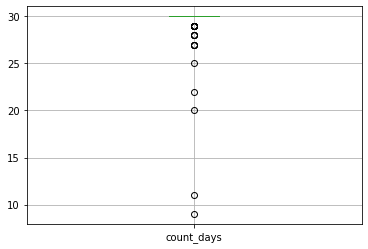

In [25]:
tmp_waste_1.boxplot(column = 'count_days') 
# dropping the container with count_days = 9: from the data it seems that it had been turned off after 9 days

# BUT, if using visualisation with aggregationg, it would be probably required to drop all containers with count_days < 30 -
# loosing 1836 observations only (less than 2% of observations + these have average of 3.08 measurements/day
# + most of them having 2+ measurements taking place in the same hour) -->
# by deleting all these, overall average would increase from 5.28 to 5.38 measurements/day

In [26]:
waste['cnt_days_30'] = np.where(waste['container_id'] < 30, 0, 1) # marking containers with less than 30 days of measurements

In [27]:
waste.drop(waste[waste['container_id'] == 30409 ].index, inplace = True) # deleting above mentioned container, now 423 cont.

In [28]:
waste.shape # checking dimension, having now 401 containers

(66564, 16)

In [29]:
waste['prediction_utc'].describe()  # range between 11.4.2019 and 4.5.2023

C:\Users\ajuse\AppData\Local\Temp/ipykernel_12796/2818655384.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  waste['prediction_utc'].describe()  # range between 11.4.2019 and 4.5.2023


count                         45557
unique                          285
top       2019-04-12 15:24:41+00:00
freq                            195
first     2019-04-11 01:19:06+00:00
last      2023-05-04 03:10:05+00:00
Name: prediction_utc, dtype: object

In [30]:
waste[['container_id', 'code', 'prediction_utc']].drop_duplicates() # 423, i.e., one prediction per each container

,container_id,code,prediction_utc
0,30133,S0133C01336,2019-05-13 12:39:17+00:00
3,30142,S0135C01353,NaT
4,30040,S0050C00502,2019-04-14 21:43:38+00:00
5,30081,S0058C00582,2019-04-12 10:33:23+00:00
6,30150,S0137C01371,2019-04-14 03:35:05+00:00
...,...,...,...
1650,30323,S0140C01405,NaT
2025,29907,S0021C00214,2019-04-29 14:03:48+00:00
2137,29825,S0026C00262,2019-05-28 02:37:57+00:00
4398,30143,S0135C01354,2019-04-11 01:19:06+00:00


In [31]:
### Before analysing variables related to measurements in more detail - reading Containers info and join with measurements data
path = "C:/Users/ajuse/OneDrive/Documents/Koljuska/Personal/Interview/Operator_ict" # change to your path, please
os.chdir(path)

In [32]:
## Opening json
with open('Containers.geojson', encoding = "utf-8") as f:
    tmp_containers = json.load(f, encoding = "utf-8")

In [33]:
containers = pd.DataFrame([feature['properties'] for feature in tmp_containers['features']]) # Creating dataframe

In [34]:
containers.info() # 'prediction', 'installed_at' - missing values
containers.head(5) # original data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            424 non-null    int64  
 1   code          424 non-null    object 
 2   latitude      424 non-null    float64
 3   longitude     424 non-null    float64
 4   address       424 non-null    object 
 5   district      140 non-null    object 
 6   postal_code   424 non-null    object 
 7   total_volume  424 non-null    int64  
 8   trash_type    424 non-null    object 
 9   prediction    312 non-null    object 
 10  bin_type      424 non-null    object 
 11  installed_at  418 non-null    object 
dtypes: float64(2), int64(2), object(8)
memory usage: 39.9+ KB


,id,code,latitude,longitude,address,district,postal_code,total_volume,trash_type,prediction,bin_type,installed_at
0,29866,S0001C00011,50.088839,14.410216,Cihelná 548,None,11000,3000,plastic,None,Schäfer/Europa-OV,2018-12-18T00:00:00.000Z
1,29867,S0001C00012,50.088839,14.410216,Cihelná 548,None,11000,3000,paper,None,Schäfer/Europa-OV,2018-12-18T00:00:00.000Z
2,29882,S0002C00021,50.090378,14.423075,Haštalská 748,None,11000,3000,paper,None,Schäfer/Europa-OV,2018-12-18T00:00:00.000Z
3,29883,S0002C00022,50.090378,14.423075,Haštalská 748,None,11000,3000,plastic,2019-04-13T22:39:24.000Z,Schäfer/Europa-OV,2018-12-18T00:00:00.000Z
4,29884,S0002C00023,50.090378,14.423075,Haštalská 748,None,11000,1500,beverage_cartons,None,Schäfer/Europa-OV,2018-12-18T00:00:00.000Z


In [33]:
## Variables 'id' and 'code' - unique indetification of a container --> used to join all the data
## Variables 'adress' and 'postal_code' - full data
## Variables 'latitute' and 'longitutde' - geographical coordinates

In [46]:
containers = containers.rename(columns = {'id': 'container_id', 'prediction': 'prediction_c'}) # rename columns for merging purposes

In [35]:
## Variable 'district' - missing most of the data (only 5 out of 424 filled) --> e.g., when creating dashboards,
# unfortunately, this can prevent to summarise the data according to respective districts,
# though these data can be easily found using postal code / coordinates
containers['district'].unique() # only Prague 1 (5x), 'TEST', and 'none' filled

array([None, 'none', 'TEST', '', 'Praha 1'], dtype=object)

In [36]:
containers[containers['district'] == 'Praha 1']

,id,code,latitude,longitude,address,district,postal_code,total_volume,trash_type,prediction,bin_type,installed_at
343,30274,P0065C00651,50.092026,14.427351,Revoluční 1044/23,Praha 1,11000,1500,glass_coloured,None,Nadzem,2018-12-18T00:00:00.000Z
344,30287,P0065C00652,50.092026,14.427351,Revoluční 1044/23,Praha 1,11000,2000,paper,2019-04-14T14:17:13.000Z,Nadzem,2018-12-18T00:00:00.000Z
345,30288,P0065C00653,50.092026,14.427351,Revoluční 1044/23,Praha 1,11000,2000,plastic,2019-04-12T22:43:28.000Z,Nadzem,2018-12-18T00:00:00.000Z
346,30290,P0065C00655,50.092026,14.427351,Revoluční 1044/23,Praha 1,11000,1500,metal,2019-04-18T04:46:26.000Z,Nadzem,2018-12-18T00:00:00.000Z
347,30291,P0065C00656,50.092026,14.427351,Revoluční 1044/23,Praha 1,11000,1500,beverage_cartons,2019-04-21T23:42:30.000Z,Nadzem,2018-12-18T00:00:00.000Z


In [37]:
## For the dashboard purposes (task 2), I decided to estimate and complete districts based on 
# 'postal_code' (assuming no mistakes in postal codes)
containers['postal_code'].unique()

array(['11000', '15000', '16000', '19000', '17000', '10000', '13000',
       '18000', '15300'], dtype=object)

In [38]:
containers.loc[containers['postal_code'] == '11000', 'district'] = 'Praha 1'
containers.loc[containers['postal_code'] == '15000', 'district'] = 'Praha 5'                                      
containers.loc[containers['postal_code'] == '16000', 'district'] = 'Praha 6'
containers.loc[containers['postal_code'] == '19000', 'district'] = 'Praha 9'
containers.loc[containers['postal_code'] == '17000', 'district'] = 'Praha 7'
containers.loc[containers['postal_code'] == '10000', 'district'] = 'Praha 9'
containers.loc[containers['postal_code'] == '13000', 'district'] = 'Praha 3'
containers.loc[containers['postal_code'] == '10000', 'district'] = 'Praha 10'
containers.loc[containers['postal_code'] == '18000', 'district'] = 'Praha 8'
containers.loc[containers['postal_code'] == '15300', 'district'] = 'Praha 16'                                      

In [39]:
containers['district'].unique() # Check

array(['Praha 1', 'Praha 5', 'Praha 6', 'Praha 9', 'Praha 7', 'Praha 10',
       'Praha 3', 'Praha 8', 'Praha 16'], dtype=object)

In [40]:
## Variable total_volume
containers['total_volume'].unique() # total_volume in litres - 5 distinct sizes (from 1100l to 4000l)

array([3000, 1500, 4000, 1100, 2000], dtype=int64)

In [41]:
## Variable trash_type
containers['trash_type'].unique() # 6 different trash types, i.e., 'plastic', 'paper', 'beverage_cartons', 'metal',
# 'glass_coloured', and 'glass_white'

array(['plastic', 'paper', 'beverage_cartons', 'metal', 'glass_coloured',
       'glass_white'], dtype=object)

In [42]:
## Variables total_volume, trash_type
containers[['total_volume', 'trash_type']].groupby(['total_volume', 'trash_type']).first()
# different sizes across different trash types - 20 different trashes

Empty DataFrame
Columns: []
Index: [(1100, beverage_cartons), (1100, glass_coloured), (1100, glass_white), (1100, metal), (1500, beverage_cartons), (1500, glass_coloured), (1500, glass_white), (1500, metal), (1500, paper), (1500, plastic), (2000, paper), (2000, plastic), (3000, beverage_cartons), (3000, glass_coloured), (3000, glass_white), (3000, metal), (3000, paper), (3000, plastic), (4000, paper), (4000, plastic)]

In [43]:
## Mostly paper and plastic containers (102 and 97, respectively) + loosing one beverage_carton (count_days = 9)
containers.groupby('trash_type').size()

trash_type
beverage_cartons     69
glass_coloured       64
glass_white          62
metal                30
paper               102
plastic              97
dtype: int64

In [44]:
## Variable 'bin_type'
containers.groupby('bin_type').size() # Nadzem = above the ground? The rest below the groud?

bin_type
Bammens Belfast          18
Bammens Memphis         161
MINI H-A                  2
Meva Top System           4
Nadzem                   43
Schäfer/Europa-OR/GB    122
Schäfer/Europa-OV        74
dtype: int64

In [47]:
## Convert columns to pd.datetime
containers[['prediction_c', 'installed_at']] = containers[['prediction_c', 'installed_at']].apply(pd.to_datetime)

In [48]:
## Variable 'installed_at' - WILL NOT BE USED FURTHER
containers['installed_at'].describe() # all containers installed before the analysed measurements
# mostly at the beginning of 2019

C:\Users\ajuse\AppData\Local\Temp/ipykernel_12796/1411879670.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  containers['installed_at'].describe() # all containers installed before the analysed measurements


count                           418
unique                            5
top       2019-01-13 00:00:00+00:00
freq                            180
first     2018-11-27 00:00:00+00:00
last      2019-01-28 00:00:00+00:00
Name: installed_at, dtype: object

In [49]:
containers.drop(containers[containers['container_id'] == 30409 ].index, inplace = True) # loosing one beverage_carton

In [50]:
containers['installed_at'].isnull().sum() # missing 6 values

6

In [51]:
## Varible 'prediction' - Prediction of fulfillment in April
containers['prediction_c'].isnull().sum() # 112 missing values - not reliable

112

In [52]:
containers['prediction_c'].describe()

C:\Users\ajuse\AppData\Local\Temp/ipykernel_12796/3649057671.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  containers['prediction_c'].describe()


count                           311
unique                          311
top       2019-04-13 22:39:24+00:00
freq                              1
first     2019-04-11 01:19:06+00:00
last      2023-04-06 01:51:41+00:00
Name: prediction_c, dtype: object

In [53]:
### Joining both datasets together:
data = pd.merge(waste, containers, how = 'left', on = ['container_id', 'code'])
data.info()
data.tail(5) # predictions are not exactly the same in both the datasets (day looks like be the same)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66564 entries, 0 to 66563
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype                        
---  ------              --------------  -----                        
 0   id                  66564 non-null  int64                        
 1   container_id        66564 non-null  int64                        
 2   code                66564 non-null  object                       
 3   percent_calculated  66564 non-null  int64                        
 4   upturned            66564 non-null  int64                        
 5   temperature         66564 non-null  int64                        
 6   battery_status      66564 non-null  float64                      
 7   measured_at         66564 non-null  datetime64[ns, Europe/Prague]
 8   measured_at_utc     66564 non-null  datetime64[ns, UTC]          
 9   prediction_w        45557 non-null  datetime64[ns, Europe/Prague]
 10  prediction_utc      45557 non-null

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,latitude,longitude,address,district,postal_code,total_volume,trash_type,prediction_c,bin_type,installed_at
66559,11162990,30011,S0037C00375,75,0,5,3.60,2019-03-01 05:07:54+01:00,2019-03-01 04:07:54+00:00,2019-04-24 20:40:30+02:00,...,50.123219,14.490452,Bohušovická-Bílinská 504/21,Praha 9,19000,1500,glass_white,2019-04-25 01:46:38+00:00,Bammens Memphis,2019-01-13 00:00:00+00:00
66560,11162986,29899,S0004C00044,55,0,11,3.60,2019-03-01 05:07:10+01:00,2019-03-01 04:07:10+00:00,2019-05-01 23:01:07+02:00,...,50.088938,14.424032,Masná 1053,Praha 1,11000,1500,metal,2019-05-01 15:45:35+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00
66561,11162938,30140,S0135C01351,98,0,7,3.76,2019-03-01 05:04:48+01:00,2019-03-01 04:04:48+00:00,NaT,...,50.108529,14.473853,Na Rokytce 22,Praha 8,18000,3000,paper,NaT,Bammens Memphis,2019-01-13 00:00:00+00:00
66562,11161830,30125,S0132C01322,50,0,8,3.71,2019-03-01 02:06:30+01:00,2019-03-01 01:06:30+00:00,NaT,...,50.091897,14.448318,Křižíkova,Praha 8,18000,3000,plastic,NaT,Bammens Memphis,2019-01-13 00:00:00+00:00
66563,11161824,30125,S0132C01322,50,0,8,3.71,2019-03-01 02:06:19+01:00,2019-03-01 01:06:19+00:00,NaT,...,50.091897,14.448318,Křižíkova,Praha 8,18000,3000,plastic,NaT,Bammens Memphis,2019-01-13 00:00:00+00:00


In [54]:
data['prediction_date_c'] = data['prediction_c'].dt.strftime('%Y-%m-%d')

In [55]:
# Values of prediction differ across datasets (including day-time)
(data['prediction_utc'] == data['prediction_c']).value_counts()

False    56272
True     10292
dtype: int64

In [56]:
# Little improvement can be observed after eliminating time (incuding only day)
(data['prediction_date_w'] == data['prediction_date_c']).value_counts()

False    38429
True     28135
dtype: int64

In [55]:
containers['prediction_c'].isnull().sum() # 112 missing

112

In [56]:
waste[['container_id', 'code', 'prediction_utc']].drop_duplicates().isnull().sum() # 138 missing

container_id        0
code                0
prediction_utc    138
dtype: int64

In [57]:
# 'prediction_utc - date' (waste) x 'prediction - date (containers)'
data[['prediction_date_w', 'prediction_date_c']] = data[['prediction_date_w', 'prediction_date_c']].apply(pd.to_datetime)
pred_diff = data[['container_id', 'code', 'prediction_date_c']].drop_duplicates()['prediction_date_c'] - data[['container_id', 'code', 'prediction_date_w']].drop_duplicates()['prediction_date_w']
pred_diff.describe() # max 177-day difference
# which predictions choose to visualise/compare with possible predictions generated from data?

count                          276
mean     0 days 10:36:31.304347826
std      7 days 12:47:49.926117431
min             -28 days +00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:00:00
max              117 days 00:00:00
dtype: object

In [58]:
tmp_data_1 = waste.groupby(['container_id', 'code', 'measured_date']).size().reset_index(name = 'count_measured')
tmp_data_1.tail(5)

,container_id,code,measured_date,count_measured
12613,30413,S0052C00525,2019-03-26,6
12614,30413,S0052C00525,2019-03-27,6
12615,30413,S0052C00525,2019-03-28,6
12616,30413,S0052C00525,2019-03-29,6
12617,30413,S0052C00525,2019-03-30,6


In [59]:
# Variable 'measured_at_utc' - continuing:
tmp_data_1['count_measured'].describe() # mean 5.27, median 6 --> frequency was set uniformly for all containers
# to 6 measurements per day? <-- in my opinion, setting different frequencies (across sensors / days) would make more
# difficult to compare the fulfillment of different containers in different locations
# e.g., if the data is to be used for the subsequent setting of the waste picks schedule

count    12618.000000
mean         5.275321
std          1.217346
min          1.000000
25%          5.000000
50%          6.000000
75%          6.000000
max          8.000000
Name: count_measured, dtype: float64

In [59]:
tmp_data_1.count_measured.unique()

array([6, 5, 2, 1, 3, 4, 7, 8], dtype=int64)

In [60]:
# Missing / excess measurements?
counts_test = []
for level in tmp_data_1.count_measured.unique():
    x = np.asarray(tmp_data_1.loc[tmp_data_1['count_measured'] == level].groupby('container_id').size())
    counts_test.append(x)

In [61]:
for i in range(0,8):
    print(counts_test[i].max())

30
15
11
12
30
30
16
6


In [62]:
np.asarray(tmp_data_1.loc[tmp_data_1['count_measured'] == 6 ].groupby('container_id').size()) # most of containers having
# regular 6 measurements/day frequency, but

array([27, 28, 28, 28, 16, 29, 29, 27, 30, 29, 30, 30, 30, 22, 24, 18, 19,
       12, 26, 29, 29, 30, 30, 29, 16,  7, 21, 30, 27, 13, 13,  8,  5, 16,
       17, 22,  2,  5, 29, 29, 29, 28, 12, 29, 27, 18,  4,  8,  6,  9, 28,
       28, 26, 30, 30, 25, 30, 30, 30, 29, 30, 29, 30, 10,  5, 30, 29, 30,
       28,  3, 14, 20, 11, 10,  9, 13, 30, 30, 30, 29, 30, 28, 25, 28, 27,
       14, 22, 29, 29,  1,  4, 12, 30, 18,  7, 10, 24, 18,  8, 23, 25,  9,
       17, 18, 14,  4,  4, 10,  9, 30, 26, 26, 25, 10, 11, 22, 20,  7, 29,
       27, 16,  6, 29, 28, 29, 30,  8,  6, 25, 10, 22, 25,  1, 13,  6, 18,
       12, 10,  2, 14, 17, 13, 30, 12,  8, 11, 14, 28, 30, 26, 20,  9, 11,
        5,  9,  9,  1,  3,  2,  7, 10, 10,  9, 10, 18, 13, 30, 30, 30, 29,
       29, 29, 22,  3, 25, 20, 26,  1, 29, 27, 29,  9, 13, 26, 29, 27,  9,
        6, 26, 22, 30, 30, 30, 29, 30, 30, 26, 30, 29, 25, 24, 29, 30, 21,
       30,  8, 20, 29, 26, 25, 22, 29, 28, 20, 25,  1, 17,  7,  3, 15, 30,
       30, 30, 28, 30, 29

In [63]:
np.asarray(tmp_data_1.loc[tmp_data_1['count_measured'] == 3 ].groupby('container_id').size())
# 2 containers having 3 measurements/day frequency over entire 30 days-long period,

array([ 9, 13,  6,  7, 12, 15,  9, 12,  7,  1,  1, 11,  1,  2,  1,  3,  1,
        3,  7,  3,  4,  1,  4,  3,  8,  5,  6,  4,  1,  1,  3,  1,  1,  2,
        4,  6,  1,  1,  1,  5,  5,  2,  2,  6,  3,  1,  3,  2,  6,  3,  3,
        1,  4,  1,  2,  5,  3,  3,  2,  6,  1,  1,  1, 10,  7,  6,  7,  5,
        1,  8,  7,  8, 10,  6,  3,  1,  1,  2,  3,  1, 10,  1,  1,  3,  1,
       16,  1,  2,  1, 16,  3,  1,  4,  7,  3,  6,  7,  8,  2,  1,  1,  5,
        1,  1,  1,  1,  1,  9,  1,  1,  6,  6,  8,  1,  9,  2, 10,  6,  6,
        9,  7,  4, 10,  4, 11,  7,  7,  4,  7, 10,  4,  4,  3,  7,  4,  6,
       12,  5,  9,  5,  7,  9,  4,  3,  6, 10,  2,  1,  2,  1,  4,  8,  4,
        2,  4,  9, 10,  8,  2,  2,  2,  1,  1, 10,  3,  8,  4, 30, 14, 30,
       13,  3], dtype=int64)

In [64]:
np.asarray(tmp_data_1.loc[tmp_data_1['count_measured'] == 4 ].groupby('container_id').size())
# and 5 containers having 4 measurements/day frequency over entire 30 days-long period

array([ 8,  1, 14, 24,  4,  2, 18,  6,  9, 10,  1, 18,  4,  1,  4,  6, 30,
        4,  8,  3,  4,  3,  8,  8,  4,  1,  7,  9,  5,  1,  3,  7,  6,  7,
        6,  1,  8, 12,  7,  3,  6,  4,  7,  5,  5,  2,  6,  2,  3,  3,  1,
        2,  5,  1,  4,  3,  3,  3, 10,  4,  3,  5, 28,  1,  5,  3,  2,  2,
        5,  2,  5,  6, 11,  4,  2,  1,  6,  5,  1, 15,  1,  5,  1, 10,  2,
        4,  3,  3, 11,  2,  7,  1,  2,  9,  5,  7,  1,  3,  7, 12,  6,  8,
        5,  3,  6,  6,  5,  2, 13,  1,  2, 10,  2,  3,  1,  5,  9,  2,  2,
       30, 30,  1,  1,  9,  7,  2,  3,  1,  2,  8,  1,  7, 12,  3,  8,  8,
        1, 30, 21,  2,  2,  1,  5,  5,  4, 30,  1, 25,  5,  1,  3, 29,  1,
        1,  2,  1, 21,  4,  4,  2, 12,  9, 10,  1,  1,  1,  6,  2,  3, 12,
        6, 16, 10,  1,  8,  3,  5, 13,  6,  2,  3,  1,  1, 12,  7,  7,  2,
        9,  9,  5,  6,  8,  5, 21,  8,  5,  8,  2,  7,  6,  7,  7,  7,  8,
        4,  1,  2,  1,  1,  5,  3,  1,  9,  2,  9,  2,  4, 12,  9,  1, 10,
        7,  5,  1,  1,  2

In [66]:
# Missing measurements - could have resided from a bad signal.
# If frequency was truly set to 6, it could be used to depict the reliability of the data transmission from sensors.
# Assuming that the frequency was set to 6 measures/day, higher frequency of data transmission could
# then also be caused by an error in the sensor (e.g., sending data on the same day and almost the same time).

In [65]:
data = pd.merge(data, tmp_data_1, how = 'left', on = ['container_id', 'code', 'measured_date']) # adding counts
data.info() # 66564

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66564 entries, 0 to 66563
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype                        
---  ------              --------------  -----                        
 0   id                  66564 non-null  int64                        
 1   container_id        66564 non-null  int64                        
 2   code                66564 non-null  object                       
 3   percent_calculated  66564 non-null  int64                        
 4   upturned            66564 non-null  int64                        
 5   temperature         66564 non-null  int64                        
 6   battery_status      66564 non-null  float64                      
 7   measured_at         66564 non-null  datetime64[ns, Europe/Prague]
 8   measured_at_utc     66564 non-null  datetime64[ns, UTC]          
 9   prediction_w        45557 non-null  datetime64[ns, Europe/Prague]
 10  prediction_utc      45557 non-null

In [66]:
tmp_2_waste = data.sort_values(['container_id', 'code', 'measured_at_utc'], ascending = (True, True, True))
# tmp_2_waste.set_index(['container_id', 'code', 'measured_date'], inplace = False) # sorting in order to calculate diffs

In [67]:
tmp_2_waste['diffs'] = tmp_2_waste.groupby(['container_id', 'code', 'measured_date'])['measured_at_utc'].diff()

In [68]:
print(tmp_2_waste['diffs'].describe()) # mean 2:36:51 / median 2 hours

count                        53946
mean     0 days 02:36:51.765728691
std      0 days 01:15:58.653789206
min                0 days 00:00:06
25%                0 days 02:00:19
50%                0 days 02:00:20
75%                0 days 03:00:29
max                0 days 15:59:59
Name: diffs, dtype: object


In [69]:
tmp_2_waste[tmp_2_waste['diffs'] <= dt.timedelta(minutes = 60)] # identifying cases where sensors probably mistakenly
# sent data during the same day but also within one hour --> such measurements can be misleading ("no added value")
# 1683 observations --> dropping these and loosing approx. 2% of observations

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,district,postal_code,total_volume,trash_type,prediction_c,bin_type,installed_at,prediction_date_c,count_measured,diffs
63552,11182928,29786,S0020C00201,23,0,5,3.60,2019-03-02 10:01:37+01:00,2019-03-02 09:01:37+00:00,2019-05-08 02:59:19+02:00,...,Praha 6,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,5,0 days 00:02:52
64646,11174173,29788,S0020C00203,33,0,3,3.82,2019-03-01 18:07:36+01:00,2019-03-01 17:07:36+00:00,NaT,...,Praha 6,16000,3000,paper,NaT,Bammens Belfast,2018-11-27 00:00:00+00:00,NaT,2,0 days 00:00:10
59737,11211539,29788,S0020C00203,99,0,1,3.81,2019-03-04 06:07:33+01:00,2019-03-04 05:07:33+00:00,NaT,...,Praha 6,16000,3000,paper,NaT,Bammens Belfast,2018-11-27 00:00:00+00:00,NaT,3,0 days 00:00:09
51206,11270716,29788,S0020C00203,99,0,5,3.82,2019-03-07 18:07:35+01:00,2019-03-07 17:07:35+00:00,NaT,...,Praha 6,16000,3000,paper,NaT,Bammens Belfast,2018-11-27 00:00:00+00:00,NaT,2,0 days 00:00:10
46188,11311990,29788,S0020C00203,81,0,-1,3.81,2019-03-10 06:07:32+01:00,2019-03-10 05:07:32+00:00,NaT,...,Praha 6,16000,3000,paper,NaT,Bammens Belfast,2018-11-27 00:00:00+00:00,NaT,3,0 days 00:00:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26923,11462455,30407,S0160C01602,47,0,6,3.68,2019-03-18 18:06:38+01:00,2019-03-18 17:06:38+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,2,0 days 00:00:08
24284,11486473,30407,S0160C01602,34,0,2,3.67,2019-03-20 06:06:35+01:00,2019-03-20 05:06:35+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,4,0 days 00:00:08
20275,11515592,30407,S0160C01602,91,0,12,3.72,2019-03-21 18:06:36+01:00,2019-03-21 17:06:36+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,4,0 days 00:00:09
15644,11551114,30407,S0160C01602,41,0,14,3.73,2019-03-23 18:06:33+01:00,2019-03-23 17:06:33+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,4,0 days 00:00:08


In [70]:
tmp_2_waste[tmp_2_waste['diffs'] < dt.timedelta(minutes = 120)] # 3562 below 2 hours - dropping these would lead to a loss
# of approx. 5% (stick to the first case, i.e., drop those within one hour, given also the fact that median = 2)

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,district,postal_code,total_volume,trash_type,prediction_c,bin_type,installed_at,prediction_date_c,count_measured,diffs
63552,11182928,29786,S0020C00201,23,0,5,3.60,2019-03-02 10:01:37+01:00,2019-03-02 09:01:37+00:00,2019-05-08 02:59:19+02:00,...,Praha 6,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,5,0 days 00:02:52
48193,11296338,29786,S0020C00201,29,0,4,3.60,2019-03-09 08:01:53+01:00,2019-03-09 07:01:53+00:00,2019-05-08 02:59:19+02:00,...,Praha 6,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 01:34:34
32754,11418778,29786,S0020C00201,30,0,4,3.60,2019-03-16 08:01:43+01:00,2019-03-16 07:01:43+00:00,2019-05-08 02:59:19+02:00,...,Praha 6,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 01:33:49
1754,11665823,29786,S0020C00201,23,0,5,3.60,2019-03-30 08:01:56+01:00,2019-03-30 07:01:56+00:00,2019-05-08 02:59:19+02:00,...,Praha 6,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 01:07:54
63842,11181615,29787,S0020C00202,32,0,8,3.60,2019-03-02 08:01:54+01:00,2019-03-02 07:01:54+00:00,2019-04-25 12:28:54+02:00,...,Praha 6,16000,1500,glass_coloured,2019-04-24 18:36:15+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-04-24,6,0 days 01:34:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26923,11462455,30407,S0160C01602,47,0,6,3.68,2019-03-18 18:06:38+01:00,2019-03-18 17:06:38+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,2,0 days 00:00:08
24284,11486473,30407,S0160C01602,34,0,2,3.67,2019-03-20 06:06:35+01:00,2019-03-20 05:06:35+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,4,0 days 00:00:08
20275,11515592,30407,S0160C01602,91,0,12,3.72,2019-03-21 18:06:36+01:00,2019-03-21 17:06:36+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,4,0 days 00:00:09
15644,11551114,30407,S0160C01602,41,0,14,3.73,2019-03-23 18:06:33+01:00,2019-03-23 17:06:33+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,4,0 days 00:00:08


In [71]:
tmp_2_waste[tmp_2_waste['diffs'] >= dt.timedelta(minutes = 360)] # opposite problem - missing measurements in between

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,district,postal_code,total_volume,trash_type,prediction_c,bin_type,installed_at,prediction_date_c,count_measured,diffs
20188,11516084,29787,S0020C00202,51,0,15,3.60,2019-03-21 18:22:10+01:00,2019-03-21 17:22:10+00:00,2019-04-25 12:28:54+02:00,...,Praha 6,16000,1500,glass_coloured,2019-04-24 18:36:15+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-04-24,5,0 days 06:00:56
63055,11185286,29788,S0020C00203,53,0,0,3.81,2019-03-02 12:07:25+01:00,2019-03-02 11:07:25+00:00,NaT,...,Praha 6,16000,3000,paper,NaT,Bammens Belfast,2018-11-27 00:00:00+00:00,NaT,2,0 days 06:00:01
56496,11232667,29788,S0020C00203,40,0,4,3.81,2019-03-05 12:07:24+01:00,2019-03-05 11:07:24+00:00,NaT,...,Praha 6,16000,3000,paper,NaT,Bammens Belfast,2018-11-27 00:00:00+00:00,NaT,2,0 days 06:00:00
53452,11253786,29788,S0020C00203,92,0,4,3.82,2019-03-06 18:07:25+01:00,2019-03-06 17:07:25+00:00,NaT,...,Praha 6,16000,3000,paper,NaT,Bammens Belfast,2018-11-27 00:00:00+00:00,NaT,2,0 days 06:00:01
49760,11282736,29788,S0020C00203,23,0,4,3.81,2019-03-08 12:07:24+01:00,2019-03-08 11:07:24+00:00,NaT,...,Praha 6,16000,3000,paper,NaT,Bammens Belfast,2018-11-27 00:00:00+00:00,NaT,2,0 days 06:00:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35887,11390497,30408,S0160C01603,39,0,3,3.59,2019-03-14 16:00:11+01:00,2019-03-14 15:00:11+00:00,2019-04-27 13:33:40+02:00,...,Praha 1,11000,1100,metal,2019-04-28 17:22:59+00:00,Nadzem,2019-01-28 00:00:00+00:00,2019-04-28,3,0 days 10:00:02
21100,11509293,30408,S0160C01603,49,1,7,3.59,2019-03-21 12:00:10+01:00,2019-03-21 11:00:10+00:00,2019-04-27 13:33:40+02:00,...,Praha 1,11000,1100,metal,2019-04-28 17:22:59+00:00,Nadzem,2019-01-28 00:00:00+00:00,2019-04-28,3,0 days 06:00:01
20326,11515084,30408,S0160C01603,50,1,11,3.62,2019-03-21 18:00:11+01:00,2019-03-21 17:00:11+00:00,2019-04-27 13:33:40+02:00,...,Praha 1,11000,1100,metal,2019-04-28 17:22:59+00:00,Nadzem,2019-01-28 00:00:00+00:00,2019-04-28,3,0 days 06:00:01
18872,11527222,30408,S0160C01603,54,1,9,3.59,2019-03-22 12:00:10+01:00,2019-03-22 11:00:10+00:00,2019-04-27 13:33:40+02:00,...,Praha 1,11000,1100,metal,2019-04-28 17:22:59+00:00,Nadzem,2019-01-28 00:00:00+00:00,2019-04-28,5,0 days 06:00:01


In [72]:
tmp_2_waste[(tmp_2_waste['container_id'] == 30407) & (tmp_2_waste['measured_date'] == '2019-03-25')]
# diffs < 60 identify a position of the second "duplicate" measurement <-- assuming that the first is correctly sent

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,district,postal_code,total_volume,trash_type,prediction_c,bin_type,installed_at,prediction_date_c,count_measured,diffs
13130,11574398,30407,S0160C01602,80,0,5,3.68,2019-03-25 06:06:21+01:00,2019-03-25 05:06:21+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,4,NaT
12122,11579950,30407,S0160C01602,33,0,8,3.69,2019-03-25 12:06:22+01:00,2019-03-25 11:06:22+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,4,0 days 06:00:01
12119,11579960,30407,S0160C01602,33,0,8,3.69,2019-03-25 12:06:31+01:00,2019-03-25 11:06:31+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,4,0 days 00:00:09
11339,11585639,30407,S0160C01602,38,0,7,3.69,2019-03-25 18:06:23+01:00,2019-03-25 17:06:23+00:00,NaT,...,Praha 1,11000,2000,paper,NaT,Nadzem,2019-01-28 00:00:00+00:00,NaT,4,0 days 05:59:52


In [73]:
tmp_2_waste.drop(tmp_2_waste[tmp_2_waste['diffs'] <= dt.timedelta(minutes = 60)].index, inplace = True)
tmp_2_waste.shape

(64881, 29)

In [74]:
data_prefinal = tmp_2_waste

In [75]:
# some descriptive stats after cleaning data:
data_prefinal.info()
data_prefinal.shape # (64881, 29) - 424 containers
data_prefinal.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64881 entries, 65825 to 67
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype                        
---  ------              --------------  -----                        
 0   id                  64881 non-null  int64                        
 1   container_id        64881 non-null  int64                        
 2   code                64881 non-null  object                       
 3   percent_calculated  64881 non-null  int64                        
 4   upturned            64881 non-null  int64                        
 5   temperature         64881 non-null  int64                        
 6   battery_status      64881 non-null  float64                      
 7   measured_at         64881 non-null  datetime64[ns, Europe/Prague]
 8   measured_at_utc     64881 non-null  datetime64[ns, UTC]          
 9   prediction_w        44689 non-null  datetime64[ns, Europe/Prague]
 10  prediction_utc      44689 non-nul

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,district,postal_code,total_volume,trash_type,prediction_c,bin_type,installed_at,prediction_date_c,count_measured,diffs
65825,11166902,29786,S0020C00201,20,0,7,3.6,2019-03-01 09:54:59+01:00,2019-03-01 08:54:59+00:00,2019-05-08 02:59:19+02:00,...,Praha 6,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,NaT
65515,11168645,29786,S0020C00201,20,0,8,3.6,2019-03-01 11:55:18+01:00,2019-03-01 10:55:18+00:00,2019-05-08 02:59:19+02:00,...,Praha 6,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19
65177,11170401,29786,S0020C00201,19,0,9,3.6,2019-03-01 13:55:37+01:00,2019-03-01 12:55:37+00:00,2019-05-08 02:59:19+02:00,...,Praha 6,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19
64807,11171962,29786,S0020C00201,19,0,10,3.6,2019-03-01 15:55:57+01:00,2019-03-01 14:55:57+00:00,2019-05-08 02:59:19+02:00,...,Praha 6,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:20
64708,11173666,29786,S0020C00201,19,0,8,3.6,2019-03-01 17:56:16+01:00,2019-03-01 16:56:16+00:00,2019-05-08 02:59:19+02:00,...,Praha 6,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19


In [76]:
tmp_data_2 = data_prefinal.groupby(['container_id', 'code', 'measured_date']).size().reset_index(name = 'count_measured_cln')
tmp_data_2.tail(5)

,container_id,code,measured_date,count_measured_cln
12613,30413,S0052C00525,2019-03-26,6
12614,30413,S0052C00525,2019-03-27,6
12615,30413,S0052C00525,2019-03-28,6
12616,30413,S0052C00525,2019-03-29,6
12617,30413,S0052C00525,2019-03-30,6


In [77]:
tmp_data_2['count_measured_cln'].describe() # max 6 ("duplicate" measurements dropped, i.e., sent during one hour)
# -->  25% increases to 4

count    12618.000000
mean         5.141940
std          1.251164
min          1.000000
25%          4.000000
50%          6.000000
75%          6.000000
max          6.000000
Name: count_measured_cln, dtype: float64

In [78]:
data_final = pd.merge(data_prefinal, tmp_data_2, how = 'left', on = ['container_id', 'code', 'measured_date']) # adding new counts_measured

In [79]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64881 entries, 0 to 64880
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype                        
---  ------              --------------  -----                        
 0   id                  64881 non-null  int64                        
 1   container_id        64881 non-null  int64                        
 2   code                64881 non-null  object                       
 3   percent_calculated  64881 non-null  int64                        
 4   upturned            64881 non-null  int64                        
 5   temperature         64881 non-null  int64                        
 6   battery_status      64881 non-null  float64                      
 7   measured_at         64881 non-null  datetime64[ns, Europe/Prague]
 8   measured_at_utc     64881 non-null  datetime64[ns, UTC]          
 9   prediction_w        44689 non-null  datetime64[ns, Europe/Prague]
 10  prediction_utc      44689 non-null

In [80]:
data_final[['battery_status', 'longitude', 'latitude', 'total_volume']] = data_final[['battery_status', 'longitude', 'latitude', 'total_volume']].astype(str)

In [81]:
data_final['battery_status'] = data_final['battery_status'].str.replace('.',',')
data_final['longitude'] = data_final['longitude'].str.replace('.',',')
data_final['latitude'] = data_final['latitude'].str.replace('.',',')

C:\Users\ajuse\AppData\Local\Temp/ipykernel_12796/1655295256.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_final['battery_status'] = data_final['battery_status'].str.replace('.',',')
C:\Users\ajuse\AppData\Local\Temp/ipykernel_12796/1655295256.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_final['longitude'] = data_final['longitude'].str.replace('.',',')
C:\Users\ajuse\AppData\Local\Temp/ipykernel_12796/1655295256.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data_final['latitude'] = data_final

In [82]:
data_final.to_csv('data_final.csv', sep = ',', na_rep = '', header = True, encoding = "utf-8-sig")

## 2. Dashboard
Pouze předpřipravené úvodní strany vizualizace (mapy, základní agregace) v Tableau - rozšířila bych postupně o další nápady zmíněné v sekci 4.

## 3. Dashboard for service organisation

Real-time dashboardy (za předpokladu, že by byla k dispozici aktuální data):
- Dashboard, který by měl nastavené alerty v případě vzniku požáru v kontejneru / převrácení kontejneru.
- Křivka zaplněnosti individuálních kontejnerů v čase (např. dle výběru na mapě) - alert pokud 100% po dobu několika dní $ \rightarrow $ možná potřeba úklidu.

## 4. Other ideas - continuing

#### 4.1
Pakliže by byla k dispozici přesná data o svozech uskutečněných v roce 2019, resp. jejich harmonogram / popř. frekvence (napříč městskými částmi a typy kontejnerů / pro jednotlivé kontejnery), šlo by zhodnotit efektivitu svozů, i.e., na kolik % byla nádoba zaplněna v době svozu. Tam, kde by bylo zaplnění v čase výrazně < 100% by se mohla nastavit nižší frekvence svozu, která by mohla vést k úspoře nákladů za svozy. Naopak tam, kde jsou nádoby více zaplněné v průběhu času by šla nastavit vyšší frekvence a eliminovalo by se tak riziko hromadění odpadů vedle kontejnerů, které je potřeba uklízet (další náklady na služby). Existují taková data (i real-time data)? Pokud ne, z dat by se dal den svozu (popř. přibližného času) odhadnout - akorát do toho vstupuje mnoho faktorů a podmínka: %zaplněnosti v čase t - %zaplněnosti v čase t-1 < 0 či = 0 prostě nestačí. V datech jsou opakující se speci případy, např.:

In [84]:
mask = ((data_final['container_id'] == 29883) & ((data_final['measured_date'] >= '2019-03-03') & (data_final['measured_date'] <= '2019-03-05')))
data_final.loc[mask] # zdá se, že svoz byl uskutečněn 4.3., ale hodnota naplnění postupně klesá až do 5.3., odkud začíná znovu stoupat
# chybné měření? / dle popisu se jedná spíše o podzemní kontejnery, takže možnost, že někdo postupně vybral kontejner také nepřipadá v úvahu
# kontejner nebyl převrácen / požár nebyl ohlášen
# Schaffer type převážně

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,postal_code,total_volume,trash_type,prediction_c,bin_type,installed_at,prediction_date_c,count_measured,diffs,count_measured_cln
9348,11196269,29883,S0002C00022,100,0,6,"3,6",2019-03-03 06:18:31+01:00,2019-03-03 05:18:31+00:00,2019-04-14 06:41:58+02:00,...,11000,3000,plastic,2019-04-13 22:39:24+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00,2019-04-13,6,NaT,6
9349,11197764,29883,S0002C00022,100,0,7,"3,6",2019-03-03 08:18:50+01:00,2019-03-03 07:18:50+00:00,2019-04-14 06:41:58+02:00,...,11000,3000,plastic,2019-04-13 22:39:24+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00,2019-04-13,6,0 days 02:00:19,6
9350,11199021,29883,S0002C00022,100,0,8,"3,6",2019-03-03 10:19:10+01:00,2019-03-03 09:19:10+00:00,2019-04-14 06:41:58+02:00,...,11000,3000,plastic,2019-04-13 22:39:24+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00,2019-04-13,6,0 days 02:00:20,6
9351,11201397,29883,S0002C00022,100,0,9,"3,6",2019-03-03 12:19:29+01:00,2019-03-03 11:19:29+00:00,2019-04-14 06:41:58+02:00,...,11000,3000,plastic,2019-04-13 22:39:24+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00,2019-04-13,6,0 days 02:00:19,6
9352,11202779,29883,S0002C00022,100,0,10,"3,6",2019-03-03 14:19:48+01:00,2019-03-03 13:19:48+00:00,2019-04-14 06:41:58+02:00,...,11000,3000,plastic,2019-04-13 22:39:24+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00,2019-04-13,6,0 days 02:00:19,6
9353,11206453,29883,S0002C00022,100,0,10,"3,6",2019-03-03 18:20:26+01:00,2019-03-03 17:20:26+00:00,2019-04-14 06:41:58+02:00,...,11000,3000,plastic,2019-04-13 22:39:24+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00,2019-04-13,6,0 days 04:00:38,6
9354,11212078,29883,S0002C00022,100,0,8,"3,6",2019-03-04 06:22:17+01:00,2019-03-04 05:22:17+00:00,2019-04-14 06:41:58+02:00,...,11000,3000,plastic,2019-04-13 22:39:24+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00,2019-04-13,6,NaT,6
9355,11213612,29883,S0002C00022,100,0,8,"3,6",2019-03-04 08:22:36+01:00,2019-03-04 07:22:36+00:00,2019-04-14 06:41:58+02:00,...,11000,3000,plastic,2019-04-13 22:39:24+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00,2019-04-13,6,0 days 02:00:19,6
9356,11214865,29883,S0002C00022,93,0,8,"3,6",2019-03-04 10:22:55+01:00,2019-03-04 09:22:55+00:00,2019-04-14 06:41:58+02:00,...,11000,3000,plastic,2019-04-13 22:39:24+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00,2019-04-13,6,0 days 02:00:19,6
9357,11217286,29883,S0002C00022,87,0,10,"3,6",2019-03-04 12:23:14+01:00,2019-03-04 11:23:14+00:00,2019-04-14 06:41:58+02:00,...,11000,3000,plastic,2019-04-13 22:39:24+00:00,Schäfer/Europa-OV,2018-12-18 00:00:00+00:00,2019-04-13,6,0 days 02:00:19,6


In [83]:
mask = ((data_final['container_id'] == 30360) & ((data_final['measured_date'] >= '2019-03-21') & (data_final['measured_date'] <= '2019-03-23')))
data_final.loc[mask] # ke svozu došlo pravděpodobně 22.3. (pokles z 98 % na 40% po třech hodinách a následný nárůst hodnot),
# což komplikuje stanovení podmínky, přičinou moůže být: svoz nedisponoval dostatečnou kapacitou pro vývoz celého kontejneru /
# "odfláknutý svoz" / svoz proběhl dle možné kapacity, ale s ohledem na jeho vysokou vytíženost se kontejner stačil již částečně naplnit

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,postal_code,total_volume,trash_type,prediction_c,bin_type,installed_at,prediction_date_c,count_measured,diffs,count_measured_cln
59133,11503981,30360,S0150C01503,95,0,2,"3,63",2019-03-21 06:05:05+01:00,2019-03-21 05:05:05+00:00,NaT,...,15300,3000,plastic,NaT,Schäfer/Europa-OV,2019-01-13 00:00:00+00:00,NaT,7,NaT,6
59134,11506961,30360,S0150C01503,98,0,4,"3,63",2019-03-21 09:05:05+01:00,2019-03-21 08:05:05+00:00,NaT,...,15300,3000,plastic,NaT,Schäfer/Europa-OV,2019-01-13 00:00:00+00:00,NaT,7,0 days 03:00:00,6
59135,11509643,30360,S0150C01503,98,0,15,"3,68",2019-03-21 12:05:05+01:00,2019-03-21 11:05:05+00:00,NaT,...,15300,3000,plastic,NaT,Schäfer/Europa-OV,2019-01-13 00:00:00+00:00,NaT,7,0 days 03:00:00,6
59136,11511537,30360,S0150C01503,98,0,18,"3,69",2019-03-21 14:05:06+01:00,2019-03-21 13:05:06+00:00,NaT,...,15300,3000,plastic,NaT,Schäfer/Europa-OV,2019-01-13 00:00:00+00:00,NaT,7,0 days 02:00:01,6
59137,11513410,30360,S0150C01503,99,0,15,"3,68",2019-03-21 16:05:06+01:00,2019-03-21 15:05:06+00:00,NaT,...,15300,3000,plastic,NaT,Schäfer/Europa-OV,2019-01-13 00:00:00+00:00,NaT,7,0 days 02:00:00,6
59138,11515478,30360,S0150C01503,98,0,12,"3,68",2019-03-21 18:05:06+01:00,2019-03-21 17:05:06+00:00,NaT,...,15300,3000,plastic,NaT,Schäfer/Europa-OV,2019-01-13 00:00:00+00:00,NaT,7,0 days 01:59:52,6
59139,11521960,30360,S0150C01503,98,0,4,"3,64",2019-03-22 06:05:04+01:00,2019-03-22 05:05:04+00:00,NaT,...,15300,3000,plastic,NaT,Schäfer/Europa-OV,2019-01-13 00:00:00+00:00,NaT,6,NaT,6
59140,11524973,30360,S0150C01503,98,0,6,"3,64",2019-03-22 09:05:04+01:00,2019-03-22 08:05:04+00:00,NaT,...,15300,3000,plastic,NaT,Schäfer/Europa-OV,2019-01-13 00:00:00+00:00,NaT,6,0 days 03:00:00,6
59141,11527595,30360,S0150C01503,40,0,15,"3,68",2019-03-22 12:05:04+01:00,2019-03-22 11:05:04+00:00,NaT,...,15300,3000,plastic,NaT,Schäfer/Europa-OV,2019-01-13 00:00:00+00:00,NaT,6,0 days 03:00:00,6
59142,11529448,30360,S0150C01503,50,0,17,"3,69",2019-03-22 14:05:05+01:00,2019-03-22 13:05:05+00:00,NaT,...,15300,3000,plastic,NaT,Schäfer/Europa-OV,2019-01-13 00:00:00+00:00,NaT,6,0 days 02:00:01,6


In [85]:
mask = ((data_final['container_id'] == 30351) & ((data_final['measured_date'] >= '2019-03-03') & (data_final['measured_date'] <= '2019-03-05')))
data_final.loc[mask] # svoz, když nádoba není zdaleka naplněna - 4.3.2019

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,postal_code,total_volume,trash_type,prediction_c,bin_type,installed_at,prediction_date_c,count_measured,diffs,count_measured_cln
57589,11195749,30351,S0152C01522,14,0,8,"3,6",2019-03-03 06:06:11+01:00,2019-03-03 05:06:11+00:00,2019-04-20 06:34:50+02:00,...,11000,3000,plastic,2019-04-19 16:42:51+00:00,Nadzem,2019-01-13 00:00:00+00:00,2019-04-19,6,NaT,6
57590,11197595,30351,S0152C01522,14,0,9,"3,6",2019-03-03 08:06:30+01:00,2019-03-03 07:06:30+00:00,2019-04-20 06:34:50+02:00,...,11000,3000,plastic,2019-04-19 16:42:51+00:00,Nadzem,2019-01-13 00:00:00+00:00,2019-04-19,6,0 days 02:00:19,6
57591,11198874,30351,S0152C01522,14,0,12,"3,6",2019-03-03 10:06:50+01:00,2019-03-03 09:06:50+00:00,2019-04-20 06:34:50+02:00,...,11000,3000,plastic,2019-04-19 16:42:51+00:00,Nadzem,2019-01-13 00:00:00+00:00,2019-04-19,6,0 days 02:00:20,6
57592,11200953,30351,S0152C01522,14,0,14,"3,6",2019-03-03 12:07:09+01:00,2019-03-03 11:07:09+00:00,2019-04-20 06:34:50+02:00,...,11000,3000,plastic,2019-04-19 16:42:51+00:00,Nadzem,2019-01-13 00:00:00+00:00,2019-04-19,6,0 days 02:00:19,6
57593,11202570,30351,S0152C01522,14,0,14,"3,6",2019-03-03 14:07:28+01:00,2019-03-03 13:07:28+00:00,2019-04-20 06:34:50+02:00,...,11000,3000,plastic,2019-04-19 16:42:51+00:00,Nadzem,2019-01-13 00:00:00+00:00,2019-04-19,6,0 days 02:00:19,6
57594,11206007,30351,S0152C01522,17,0,12,"3,6",2019-03-03 18:08:15+01:00,2019-03-03 17:08:15+00:00,2019-04-20 06:34:50+02:00,...,11000,3000,plastic,2019-04-19 16:42:51+00:00,Nadzem,2019-01-13 00:00:00+00:00,2019-04-19,6,0 days 04:00:47,6
57595,11211798,30351,S0152C01522,33,0,10,"3,6",2019-03-04 06:09:57+01:00,2019-03-04 05:09:57+00:00,2019-04-20 06:34:50+02:00,...,11000,3000,plastic,2019-04-19 16:42:51+00:00,Nadzem,2019-01-13 00:00:00+00:00,2019-04-19,6,NaT,6
57596,11213427,30351,S0152C01522,0,0,10,"3,6",2019-03-04 08:10:16+01:00,2019-03-04 07:10:16+00:00,2019-04-20 06:34:50+02:00,...,11000,3000,plastic,2019-04-19 16:42:51+00:00,Nadzem,2019-01-13 00:00:00+00:00,2019-04-19,6,0 days 02:00:19,6
57597,11214726,30351,S0152C01522,1,0,13,"3,6",2019-03-04 10:10:35+01:00,2019-03-04 09:10:35+00:00,2019-04-20 06:34:50+02:00,...,11000,3000,plastic,2019-04-19 16:42:51+00:00,Nadzem,2019-01-13 00:00:00+00:00,2019-04-19,6,0 days 02:00:19,6
57598,11217009,30351,S0152C01522,2,0,21,"3,6",2019-03-04 12:10:55+01:00,2019-03-04 11:10:55+00:00,2019-04-20 06:34:50+02:00,...,11000,3000,plastic,2019-04-19 16:42:51+00:00,Nadzem,2019-01-13 00:00:00+00:00,2019-04-19,6,0 days 02:00:20,6


In [86]:
mask = ((data_final['container_id'] == 29786) & ((data_final['measured_date'] >= '2019-03-01') & (data_final['measured_date'] <= '2019-03-05')))
data_final.loc[mask] # hodnota naplněnosti v čase mírně kolísá směrem dolů

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,postal_code,total_volume,trash_type,prediction_c,bin_type,installed_at,prediction_date_c,count_measured,diffs,count_measured_cln
0,11166902,29786,S0020C00201,20,0,7,"3,6",2019-03-01 09:54:59+01:00,2019-03-01 08:54:59+00:00,2019-05-08 02:59:19+02:00,...,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,NaT,6
1,11168645,29786,S0020C00201,20,0,8,"3,6",2019-03-01 11:55:18+01:00,2019-03-01 10:55:18+00:00,2019-05-08 02:59:19+02:00,...,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19,6
2,11170401,29786,S0020C00201,19,0,9,"3,6",2019-03-01 13:55:37+01:00,2019-03-01 12:55:37+00:00,2019-05-08 02:59:19+02:00,...,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19,6
3,11171962,29786,S0020C00201,19,0,10,"3,6",2019-03-01 15:55:57+01:00,2019-03-01 14:55:57+00:00,2019-05-08 02:59:19+02:00,...,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:20,6
4,11173666,29786,S0020C00201,19,0,8,"3,6",2019-03-01 17:56:16+01:00,2019-03-01 16:56:16+00:00,2019-05-08 02:59:19+02:00,...,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19,6
5,11176510,29786,S0020C00201,20,0,6,"3,6",2019-03-01 21:56:54+01:00,2019-03-01 20:56:54+00:00,2019-05-08 02:59:19+02:00,...,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 04:00:38,6
6,11182866,29786,S0020C00201,23,0,4,"3,6",2019-03-02 09:58:45+01:00,2019-03-02 08:58:45+00:00,2019-05-08 02:59:19+02:00,...,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,5,NaT,4
7,11184791,29786,S0020C00201,23,0,5,"3,6",2019-03-02 12:01:56+01:00,2019-03-02 11:01:56+00:00,2019-05-08 02:59:19+02:00,...,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,5,0 days 02:00:19,4
8,11186604,29786,S0020C00201,23,0,6,"3,6",2019-03-02 14:02:16+01:00,2019-03-02 13:02:16+00:00,2019-05-08 02:59:19+02:00,...,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,5,0 days 02:00:20,4
9,11189839,29786,S0020C00201,26,0,6,"3,6",2019-03-02 18:02:54+01:00,2019-03-02 17:02:54+00:00,2019-05-08 02:59:19+02:00,...,16000,1500,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,5,0 days 04:00:38,4


Tyto "komplikace"/chyby v měření by měly být brány v potaz (stejně jako nepravidelná frekvence zasílání dat způsobená např. výpadky signálu - viz výše), nicméně ztěžují určení data svozu. Datum svozu by tak šlo určit např. tak, že se by stanovila podmínka 
$ \delta < -threshold $ (určený z dat, třeba i zagregovaných po m. částech a/nebo kontejnerech).

#### 4.2
Frekvence: Zkusit z dat odhadnout dobu naplnění kontejneru z proměnné 'percent_calculated' a 'total_volume' pomocí jednotlivých přírůstků mezi jednotlivými měřeními, něco ve smyslu $\rightarrow $ 1. vynásobit procentuální přírůstek (pakliže delta > 0) a objem příslušného kontejneru. Průměrné přírůstky kumulativně sečíst a porovnat s celkovým objemem a najít tak datum, kdy došlo ke 100% naplnění, z čehož lze odvodit délku trvání naplnění (ve dnech). / spíš: 2. Objem kontejneru vydělit průměrným denním přírůstkem (bere v potaz různost rychlost v různých dnech a vypočítá průměr). Tato čísla porovnat s původními predikcemi v datasetu (ačkoli těžko říct se kterými s ohledem na fakt, že se v obou datasetech liší). Taková data by šla posléze zagregovat i na úrovni městských částí a typů kontejnerů, což si troufám říci, je informace, který by mohla referenty jednotlivých městských částí zajímat.
Potřeba data více pročistit a ponechat pouze pozorování, kde jsou k dispozici informace z každého dne měření (kvůli zachování kontinuity).

In [136]:
# 1
tmp_3_waste = tmp_2_waste.sort_values(['container_id', 'code', 'measured_at_utc'], ascending = (True, True, True))
tmp_3_waste['diffs_perc'] = tmp_3_waste.groupby(['container_id', 'code'])['percent_calculated'].diff()
tmp_3_waste.loc[tmp_3_waste['diffs_perc'] < 0, 'diffs_perc'] = 0
tmp_3_waste['delta_volume'] = tmp_3_waste['total_volume'] * ((tmp_3_waste['diffs_perc']) / 100)
tmp_3_waste.head(20)
tmp_3_waste['delta_sum'] = tmp_3_waste.groupby(['container_id', 'code'])['delta_volume'].cumsum()
tmp_3_waste.loc[tmp_3_waste['container_id'] == 29786]

,id,container_id,code,percent_calculated,upturned,temperature,battery_status,measured_at,measured_at_utc,prediction_w,...,trash_type,prediction_c,bin_type,installed_at,prediction_date_c,count_measured,diffs,diffs_perc,delta_volume,delta_sum
65825,11166902,29786,S0020C00201,20,0,7,3.6,2019-03-01 09:54:59+01:00,2019-03-01 08:54:59+00:00,2019-05-08 02:59:19+02:00,...,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,NaT,NaN,NaN,NaN
65515,11168645,29786,S0020C00201,20,0,8,3.6,2019-03-01 11:55:18+01:00,2019-03-01 10:55:18+00:00,2019-05-08 02:59:19+02:00,...,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19,0.0,0.0,0.0
65177,11170401,29786,S0020C00201,19,0,9,3.6,2019-03-01 13:55:37+01:00,2019-03-01 12:55:37+00:00,2019-05-08 02:59:19+02:00,...,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19,0.0,0.0,0.0
64807,11171962,29786,S0020C00201,19,0,10,3.6,2019-03-01 15:55:57+01:00,2019-03-01 14:55:57+00:00,2019-05-08 02:59:19+02:00,...,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:20,0.0,0.0,0.0
64708,11173666,29786,S0020C00201,19,0,8,3.6,2019-03-01 17:56:16+01:00,2019-03-01 16:56:16+00:00,2019-05-08 02:59:19+02:00,...,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,11665823,29786,S0020C00201,23,0,5,3.6,2019-03-30 08:01:56+01:00,2019-03-30 07:01:56+00:00,2019-05-08 02:59:19+02:00,...,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 01:07:54,1.0,15.0,1755.0
1398,11667201,29786,S0020C00201,22,0,8,3.6,2019-03-30 10:02:13+01:00,2019-03-30 09:02:13+00:00,2019-05-08 02:59:19+02:00,...,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:17,0.0,0.0,1755.0
1071,11669163,29786,S0020C00201,22,0,11,3.6,2019-03-30 12:02:32+01:00,2019-03-30 11:02:32+00:00,2019-05-08 02:59:19+02:00,...,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19,0.0,0.0,1755.0
741,11671099,29786,S0020C00201,22,0,16,3.6,2019-03-30 14:02:51+01:00,2019-03-30 13:02:51+00:00,2019-05-08 02:59:19+02:00,...,beverage_cartons,2019-05-06 10:41:41+00:00,Bammens Belfast,2018-11-27 00:00:00+00:00,2019-05-06,6,0 days 02:00:19,0.0,0.0,1755.0


#### 4.3

**Další nápady:**

- porovnání (prům.) přírůstku v jednotlivých dnech (pracovní dny vs víkendy), i.e., "vytíženost" kontejnerů
- analýzy týkající se objemu vyvezeného odpadu (městské části / porovnání jednotlivých druhů kontejnerů)
- nápady zmíněné v textu